In [1]:
# Import required packages for this chapter
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import matplotlib.pylab as plt

from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary

%matplotlib inline

no display found. Using non-interactive Agg backend


In [2]:
imdb_df = pd.read_csv('projectData.csv')
imdb_df = imdb_df.set_index('tconst')

imdb_df = imdb_df.drop('numVotes', axis=1)
imdb_df = imdb_df.drop('writers', axis=1)

In [3]:
genres_df = imdb_df['genres'].str.get_dummies(sep=',')
genres_df = genres_df.add_prefix('genre_')
imdb_df = pd.concat([imdb_df, genres_df], axis=1)
imdb_df = imdb_df.drop('genres', axis=1)


directors_df = imdb_df['directors'].str.get_dummies(sep=',')
directors_df = directors_df.add_prefix('dir_')
imdb_df = pd.concat([imdb_df, directors_df], axis=1)
imdb_df = imdb_df.drop('directors', axis=1)


actor_df = imdb_df['actor'].str.get_dummies(sep=',')
actor_df = actor_df.add_prefix('actor_')
imdb_df = pd.concat([imdb_df, actor_df], axis=1)
imdb_df = imdb_df.drop('actor', axis=1)

In [4]:
# define the bins
bins = [0, 2.4, 5.0, 7.4, 10]

# define the bin labels
labels = ['Terrible', 'Poor', 'Average', 'Excellent']

# create a new column with the bin labels
imdb_df['binRating'] = pd.cut(imdb_df['averageRating'], bins=bins, labels=labels, include_lowest=True)

imdb_df = imdb_df.drop('averageRating', axis=1)
imdb_df = pd.get_dummies(imdb_df, columns=['binRating'], prefix='bin')
imdb_df.head()

,runtimeMinutes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,...,actor_nm9500254,actor_nm9503133,actor_nm9576872,actor_nm9858131,actor_nm9862858,actor_nm9877392,bin_Terrible,bin_Poor,bin_Average,bin_Excellent
tconst,,,,,,,,,,,,,,,,,,,,,
tt0035423,118,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
tt0118589,104,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
tt0118694,98,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
tt0120202,105,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
tt0120630,84,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
X = imdb_df.drop(['bin_Average', 'bin_Excellent', 'bin_Poor', 'bin_Terrible'], axis=1)
y = imdb_df[['bin_Excellent']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=102)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rfc = RandomForestClassifier(n_estimators=100, random_state=102)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

/var/folders/d4/ypbwpx292519124yys2bmqwh0000gn/T/ipykernel_75241/907939598.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.8461538461538461


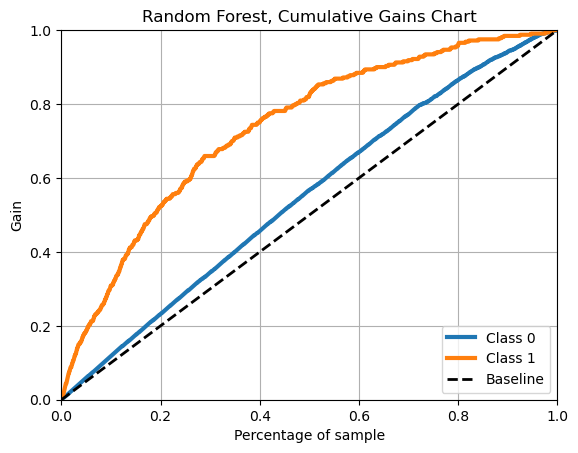

In [12]:
# Make predictions on the testing set
y_pred = rfc.predict(X_test)

# Get the predicted probabilities for each class
pred_prob = rfc.predict_proba(X_test)

import scikitplot as skplt

# Plot the gains chart for the random forest model
skplt.metrics.plot_cumulative_gain(y_test, pred_prob)
plt.title('Random Forest, Cumulative Gains Chart')
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predict the labels for the testing set
rfc_pred = rfc.predict(X_test)

# Calculate the mean squared error (MSE) and root mean squared error (RMSE)
mse = mean_squared_error(y_test, rfc_pred)
rmse = sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 0.15384615384615385
RMSE: 0.3922322702763681


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, rfc_pred))
print(confusion_matrix(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1591
           1       0.65      0.17      0.28       320

    accuracy                           0.85      1911
   macro avg       0.75      0.58      0.59      1911
weighted avg       0.82      0.85      0.81      1911

[[1561   30]
 [ 264   56]]


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 30, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1)

y_train = y_train.values.ravel()
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rfc = RandomForestClassifier(max_depth=None,max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=102)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8472004186289901


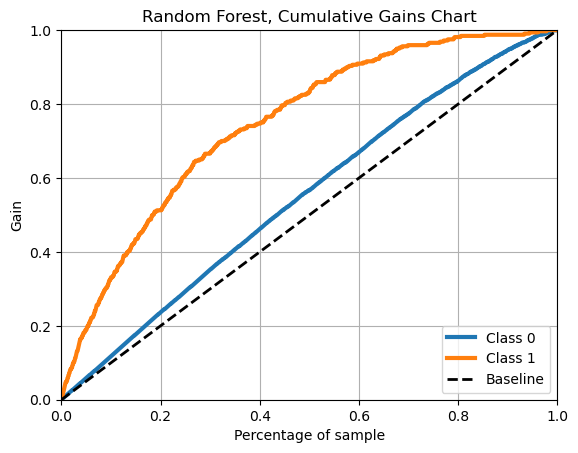

In [21]:
# Make predictions on the testing set
y_pred = rfc.predict(X_test)

# Get the predicted probabilities for each class
pred_prob = rfc.predict_proba(X_test)

import scikitplot as skplt

# Plot the gains chart for the random forest model
skplt.metrics.plot_cumulative_gain(y_test, pred_prob)
plt.title('Random Forest, Cumulative Gains Chart')
plt.show()